# Fraud Detection of Credit Card Transactions

## Project Overview:


This project focused on developing a robust machine learning model to detect fraudulent transactions. Through comprehensive data analysis, preprocessing, model training, and evaluation, the project leveraged a range of technologies to address the challenges inherent in fraud detection.

## Import

In [0]:
dbutils.library.restartPython()
# pip install azure-storage-blob pandas numpy imblearn scipy scikit-learn dash pandas plotly
# pip install --upgrade scipy scikit-learn threadpoolctl 

In [0]:
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
import pandas as pd
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, make_scorer, precision_recall_curve, auc, f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

## Meta

In [0]:
connect_str = "DefaultEndpointsProtocol=https;AccountName=stgfinancialanalysis;AccountKey=goADDOu0wTscv9k97Zy7/vndYBE45jGalIZ0turswP77U2+0kJBc8Mlit7dYolCZiWI1r2uaEk40+AStoAoBUg==;EndpointSuffix=core.windows.net"
sas_token = "?sv=2022-11-02&ss=bfqt&srt=sco&sp=rwdlacupiytfx&se=2024-02-07T18:19:14Z&st=2024-02-07T10:19:14Z&spr=https,http&sig=z6z4hp53zaHU9kK9CpUWNGg4vZOWdZlI3uuljFJWqIM%3D"

storage_account_name = "stgfinancialanalysis"
container_name = "creditcardfraud-container"
blob_name = "creditcard.csv"

## Data

In [0]:
def read_blob_into_df(blob_name):
    blob_client = container_client.get_blob_client(blob_name)
    blob_data = blob_client.download_blob().readall()
    return pd.read_csv(StringIO(blob_data.decode('utf-8')))

In [0]:
blob_url = f"https://{storage_account_name}.blob.core.windows.net"
blob_service_client = BlobServiceClient(account_url=blob_url, credential=sas_token)
container_client = blob_service_client.get_container_client(container_name)

print("Listing blobs in container...")
for blob in container_client.list_blobs():
    print("\t" + blob.name)


Listing blobs in container...
	creditcard.csv


In [0]:
dfs = {}
data = read_blob_into_df(blob_name)
print(f"Loaded {blob_name} into DataFrame.")

Loaded creditcard.csv into DataFrame.


In [0]:
# df = data.sample(n=6000, random_state=42)
df = data.copy()
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Feature Engineering

In [0]:
data['HourOfDay'] = np.floor(data['Time'] / 3600) % 24  # Convert seconds to hours and get the hour of the day

data['LogAmount'] = np.log(data['Amount'] + 1)  # Log transform to reduce skewness; +1 to handle transactions with Amount 0

# Cyclical Feature Engineering
data['HourSin'] = np.sin(2 * np.pi * data['HourOfDay'] / 24)
data['HourCos'] = np.cos(2 * np.pi * data['HourOfDay'] / 24)

# Rolling Window Statistics
# As an example, calculate the rolling mean of 'Amount' over a window of 10 transactions
# df['RollingMeanAmount'] = df['LogAmount'].rolling(window=10).mean()


## Feature Selection

In [0]:
def apply_scaling(X, method='standard', return_type='df'):
    if method == 'standard':
        scaler = StandardScaler()
    elif method == 'minmax':
        scaler = MinMaxScaler()
    else:
        raise ValueError("Unsupported scaling method. Choose 'standard' or 'minmax'.")
    
    X_scaled = scaler.fit_transform(X)
    if return_type == 'df':
        return pd.DataFrame(X_scaled, columns=X.columns)
    elif return_type == 'np':
        return X_scaled
    else:
        raise ValueError("Unsupported return type. Choose 'df' or 'array'.")


In [0]:
def select_features_pearson(X, y, threshold=0.1):
    corr_with_target = X.corrwith(y).abs()
    selected_features = corr_with_target[corr_with_target > threshold].index.tolist()
    return selected_features

def select_features_decision_tree(X, y, threshold=0.01):
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X, y)
    important_features = [feature for importance, feature in zip(clf.feature_importances_, X.columns) if importance > threshold]
    return important_features


def select_features_lasso(X, y, cv=5):
    lasso = LassoCV(cv=cv, random_state=42).fit(X, y)
    important_features = X.columns[lasso.coef_ != 0].tolist()
    return important_features


def select_features_chi2(X, y, k=10):
    chi_selector = SelectKBest(chi2, k=k)
    chi_selector.fit(X, y)
    selected_features = X.columns[chi_selector.get_support(indices=True)].tolist()
    return selected_features

In [0]:
def evaluate_feature_set(X, y, selected_features):
    X_selected = X[selected_features]
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return classification_report(y_test, y_pred, zero_division=1)


### Evaluation of Feature Sets

In [0]:
df = data.copy()
X = df.drop(['Class'], axis=1)  
y = df['Class']

In [0]:
X_standard_df = apply_scaling(X, method='standard', return_type='df')
X_standard_df.reset_index(drop=True, inplace=True)

X_minmax_df = apply_scaling(X, method='minmax', return_type='df')
X_minmax_df.reset_index(drop=True, inplace=True)

y.reset_index(drop=True, inplace=True)

In [0]:
features_pearson = select_features_pearson(X_standard_df, y, 0.2)
print("Selected features using Pearson's Coefficient:", features_pearson)
print("\n\nPearson's Coefficient Performance:")
print(evaluate_feature_set(X_standard_df, y, features_pearson))

Selected features using Pearson's Coefficient: ['V10', 'V12', 'V14', 'V17']


Pearson's Coefficient Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.93      0.82      0.88       136

    accuracy                           1.00     85443
   macro avg       0.97      0.91      0.94     85443
weighted avg       1.00      1.00      1.00     85443



In [0]:
features_chi2 = select_features_chi2(X_minmax_df, y, k=10)
print("Selected features using Chi-Squared Test:", features_chi2)
print("\n\nChi-Squared Test Performance:")
print(evaluate_feature_set(X_minmax_df, y, features_chi2))

Selected features using Chi-Squared Test: ['V4', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'HourOfDay', 'HourSin']


Chi-Squared Test Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.95      0.81      0.87       136

    accuracy                           1.00     85443
   macro avg       0.97      0.90      0.94     85443
weighted avg       1.00      1.00      1.00     85443



In [0]:
features_decision_tree = select_features_decision_tree(X_standard_df, y, 0.1)
print("Selected features using Decision Trees:", features_decision_tree)
print("\n\nDecision Trees Performance:")
print(evaluate_feature_set(X_standard_df, y, features_decision_tree))

Selected features using Decision Trees: ['V14', 'V17']


Decision Trees Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.86      0.72      0.78       136

    accuracy                           1.00     85443
   macro avg       0.93      0.86      0.89     85443
weighted avg       1.00      1.00      1.00     85443



In [0]:
features_lasso = select_features_lasso(X_standard_df, y)
print("Selected features using Lasso Regularization:", features_lasso)
print("\n\nLasso Regularization Performance:")
print(evaluate_feature_set(X_standard_df, y, features_lasso))


Selected features using Lasso Regularization: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'V21']


Lasso Regularization Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.93      0.82      0.88       136

    accuracy                           1.00     85443
   macro avg       0.97      0.91      0.94     85443
weighted avg       1.00      1.00      1.00     85443



## Class Imbalancing Handling

In [0]:
def resample_dataset(X, y, strategy='smote'):
    if strategy == 'smote':
        resampler = SMOTE(random_state=42)
    elif strategy == 'under':
        resampler = RandomUnderSampler(random_state=42)
    else:
        raise ValueError("Unsupported resampling strategy. Choose 'smote' or 'under'.")
    
    X_res, y_res = resampler.fit_resample(X, y)
    return X_res, y_res


### Cross Validation of Resampling

In [0]:
def pr_auc(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)


def validate_resampling(X, y, type='smote'):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    classifier = RandomForestClassifier(random_state=42)

    if type == 'smote':
        pipeline = make_pipeline(SMOTE(random_state=42), classifier)
    elif type == "under":  
        pipeline = make_pipeline(RandomUnderSampler(random_state=42), classifier)
    else:
        print('invalid resampling type')
        return

    scoring = {'pr_auc': make_scorer(pr_auc)}

    cv_results = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, return_train_score=True)

    return cv_results


In [0]:
df_rs = data.sample(n=3000, random_state=42)
X = df.drop(['Class'], axis=1)  
y = df['Class']

In [0]:
results = validate_resampling(X, y, type='smote')

print(f"Mean PR AUC (Train): {np.mean(results['train_pr_auc'])}")
print(f"Mean PR AUC (Test): {np.mean(results['test_pr_auc'])}")


Mean PR AUC (Train): 1.0
Mean PR AUC (Test): 0.8630269832316138


A PR AUC of 0.86 is still considered very good, indicating that the model has a high ability to distinguish between classes even in the test set. This suggests that SMOTE has effectively addressed the class imbalance problem, improving model performance on minority class predictions.

In [0]:
results = validate_resampling(X, y, type='under')

print(f"Mean PR AUC (Train): {np.mean(results['train_pr_auc'])}")
print(f"Mean PR AUC (Test): {np.mean(results['test_pr_auc'])}")

Mean PR AUC (Train): 0.5353852169501423
Mean PR AUC (Test): 0.48664868855425825


SMOTE shows significantly better performance than Under Sampling, on both of our smaller training and test data, making it the preferred choice for dealing with class imbalance in this scenario.

## Data Preparation

In [0]:
selected_features = ['V14', 'V17', 'V10', 'V12', 'V4', 'V16', 'V11', 'V18', 'V1']
X = data[selected_features]
y = data['Class']

In [0]:
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_resampled, y_resampled = resample_dataset(X_tr, y_tr, strategy='under')
X_val, y_val = resample_dataset(X_val, y_val, strategy='under')

X_standard_np = apply_scaling(X_resampled, method='minmax', return_type='df')
X_val = apply_scaling(X_val, method='minmax', return_type='df')

y_resampled.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X_standard_np, y_resampled, test_size=0.4, random_state=42)

In [0]:
X_train.head()

,V14,V17,V10,V12,V4,V16,V11,V18,V1
256,0.800626,0.782021,0.665601,0.883542,0.309752,0.824478,0.157691,0.715912,0.964707
620,0.414984,0.503682,0.573740,0.548771,0.310638,0.548816,0.462808,0.482818,0.831718
377,0.816174,0.803346,0.666704,0.906723,0.323260,0.767967,0.211224,0.629829,0.961242
327,0.812264,0.793257,0.653077,0.891671,0.273051,0.830916,0.138791,0.720541,0.837120
465,0.662197,0.540321,0.529738,0.682883,0.373028,0.522619,0.408248,0.457748,0.736374


In [0]:
y_train.head()

256    0
620    1
377    0
327    0
465    1
Name: Class, dtype: int64

## Fraud Detection Models

In [0]:
def pr_auc_scoring(estimator, X, y_true):
    # Scoring function for PR AUC to handle model probability predictions
    probas_pred = estimator.predict_proba(X)[:, 1] 
    precision, recall, _ = precision_recall_curve(y_true, probas_pred)
    print(precision)
    print(recall)
    return auc(recall, precision)


models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(probability=True, random_state=42)
}


def evaluate_model(model, X, y):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    pr_auc_scores = cross_val_score(model, X, y, cv=cv, scoring=make_scorer(pr_auc_scoring, needs_proba=True))
    f1_scores = cross_val_score(model, X, y, cv=cv, scoring='f1')
    
    return np.mean(pr_auc_scores), np.mean(f1_scores)


def evaluate_model_performance(model_name, model, X_train, X_test, X_val, y_train, y_test, y_val):
    print(f'Evaluating {model_name} -------------------------')
    model.fit(X_train, y_train)
    
    metrics_list = []
    
    def calculate_metrics(X, y, dataset_name):
        y_prob = model.predict_proba(X)[:, 1]
        precision_vals, recall_vals, _ = precision_recall_curve(y, y_prob)
        pr_auc = auc(recall_vals, precision_vals)
        
        y_pred = model.predict(X)
        f1 = f1_score(y, y_pred)
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        metrics = {
            "Model": model_name,
            "Dataset": dataset_name,
            "PR AUC": pr_auc,
            "F1 Score": f1,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "Fitted Model": model
        } 
        metrics_list.append(metrics)

        print(f"{dataset_name} Sample probabilities:", y_prob[:5])
        print(f"{dataset_name} PR AUC:", pr_auc)
        print(f"{dataset_name} F1 Score:", f1)
        print(f"{dataset_name} Accuracy:", accuracy)
        print(f"{dataset_name} Precision:", precision)
        print(f"{dataset_name} Recall:", recall)
    
    calculate_metrics(X_test, y_test, "Test")
    calculate_metrics(X_val, y_val, "Validation")
    
    return metrics_list

In [0]:
all_metrics = []
for model_name, model in models.items():
    model_metrics = evaluate_model_performance(model_name, model, X_train, X_test, X_val, y_train, y_test, y_val)
    all_metrics.extend(model_metrics)  

metrics_df = pd.DataFrame(all_metrics)

Evaluating Random Forest -------------------------
Test Sample probabilities: [1.   0.04 0.27 0.12 0.32]
Test PR AUC: 0.9820272275436217
Test F1 Score: 0.9255663430420712
Test Accuracy: 0.9272151898734177
Test Precision: 0.9407894736842105
Test Recall: 0.910828025477707
Validation Sample probabilities: [0.06 0.12 0.16 0.1  0.1 ]
Validation PR AUC: 0.9765399626475925
Validation F1 Score: 0.9368421052631579
Validation Accuracy: 0.9387755102040817
Validation Precision: 0.967391304347826
Validation Recall: 0.9081632653061225
Evaluating KNN -------------------------
Test Sample probabilities: [1.  0.  0.4 0.  0.2]
Test PR AUC: 0.9755190970483624
Test F1 Score: 0.9215686274509803
Test Accuracy: 0.9240506329113924
Test Precision: 0.9463087248322147
Test Recall: 0.8980891719745223
Validation Sample probabilities: [0. 0. 0. 0. 0.]
Validation PR AUC: 0.976575831663665
Validation F1 Score: 0.925531914893617
Validation Accuracy: 0.9285714285714286
Validation Precision: 0.9666666666666667
Validatio

### Random Forest Results

**Test Data**
  - Test Sample probabilities: [0.99 0.03 0.23 0.14 0.16]
  - Test PR AUC: 0.9793355518356972
  - Test F1 Score: 0.9255663430420712
  - Test Accuracy: 0.9272151898734177
  - Test Precision: 0.9407894736842105
  - Test Recall: 0.910828025477707

**Validation Data**
  - Validation Sample probabilities: [0.27 0.42 0.41 0.35 0.22]
  - Validation PR AUC: 0.9792295462353696
  - Validation F1 Score: 0.9368421052631579
  - Validation Accuracy: 0.9387755102040817
  - Validation Precision: 0.967391304347826
  - Validation Recall: 0.9081632653061225


In [0]:
dbutils.fs.mount(
  source=f"wasbs://{container_name}@{storage_account_name}.blob.core.windows.net/",
  mount_point="/mnt/frauddetectiondata/my_plots",
  extra_configs={f"fs.azure.sas.{container_name}.{storage_account_name}.blob.core.windows.net": sas_token})


True

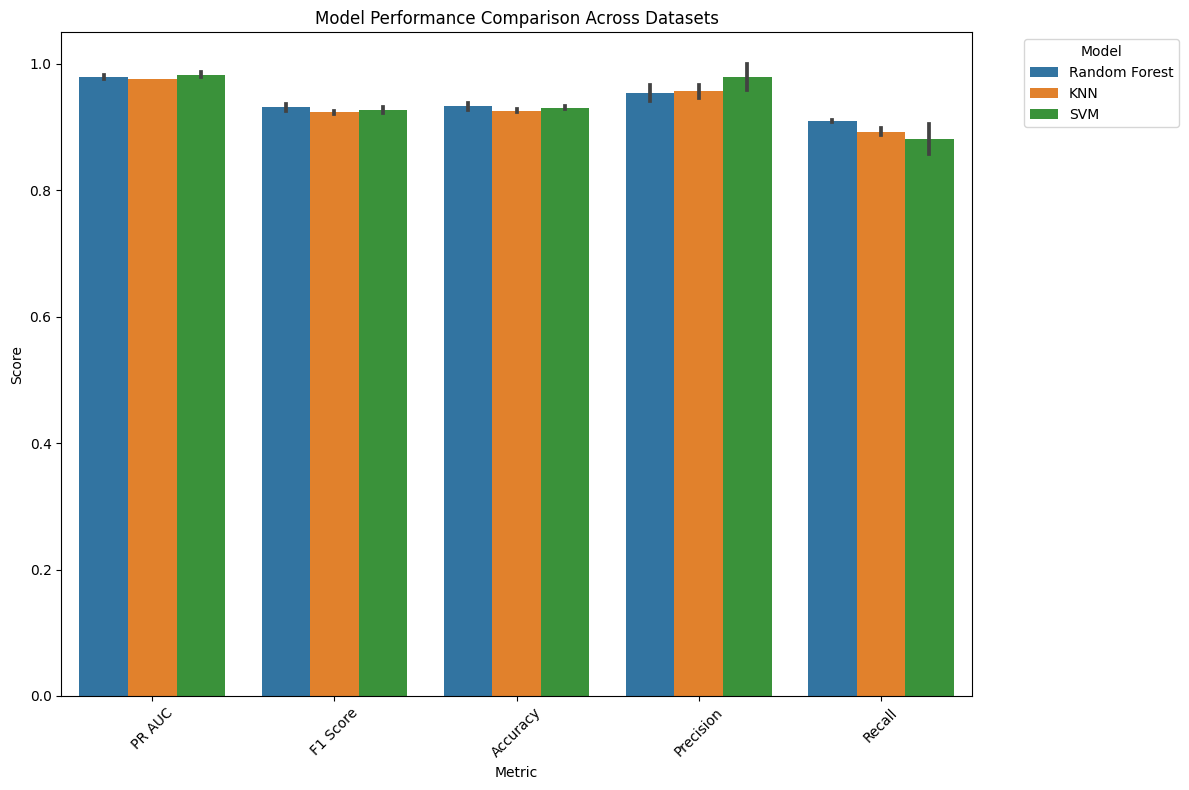

In [0]:
filtered_df = metrics_df.drop(['Fitted Model'], axis=1) 
melted_df = filtered_df.melt(id_vars=["Model", "Dataset"], var_name="Metric", value_name="Score")

melted_df['Score'] = pd.to_numeric(melted_df['Score'], errors='coerce')

if melted_df['Score'].isnull().any():
    print("NaN values found in 'Score' after conversion. Investigating:")
    print(melted_df[melted_df['Score'].isnull()])



plt.figure(figsize=(12, 8))
sns.barplot(x='Metric', y='Score', hue='Model', data=melted_df)
plt.title('Model Performance Comparison Across Datasets')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('/dbfs/mnt/frauddetectiondata/my_plots/model_performance_comparison.png', bbox_inches='tight', dpi=300)
plt.show()

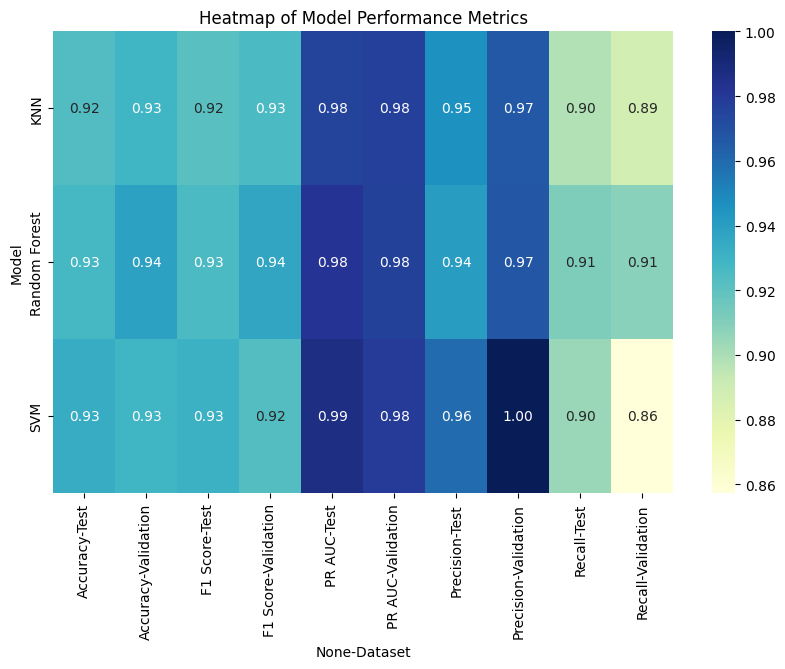

In [0]:
heatmap_data = metrics_df.pivot_table(index='Model', columns='Dataset', values=['PR AUC', 'F1 Score', 'Accuracy', 'Precision', 'Recall'], aggfunc=np.mean)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Heatmap of Model Performance Metrics')

plt.savefig('/dbfs/mnt/frauddetectiondata/my_plots/model_heatmap_comparison.png', bbox_inches='tight', dpi=300)
plt.show()

### Model Evaluation Summary:


**SVM** showed the highest PR AUC, indicating its superior capability in distinguishing between fraudulent and non-fraudulent transactions across different thresholds. High precision suggests it's very reliable when it flags a transaction as fraudulent; however, its recall is slightly lower than Random Forest, meaning it might miss some fraudulent transactions.


**Random Forest** presented a balanced performance across all metrics, with the highest F1 Score and very competitive PR AUC, Precision, and Recall. It offers a good balance between identifying fraudulent transactions (Recall) and minimizing false alarms (Precision).


**KNN** had the lowest PR AUC among the three models and slightly lower performance metrics across the board compared to Random Forest and SVM, suggesting it might not be as effective in this particular context.

### Chosen Model

Given the emphasis on better identifying fraudulent transactions:

**Random Forest** is recommended for a balanced approach, effectively identifying fraudulent transactions while maintaining a low rate of false positives. Its competitive Recall and highest F1 Score suggest it's the most versatile model for this task, making it the preferred choice if the client seeks a balance between identifying as many fraudulent transactions as possible and maintaining user trust by not flagging too many legitimate transactions as fraudulent.

In [0]:
param_grid = {
    'n_estimators': [100, 250, 500],  # Number of trees in the forest
    'max_depth': [3, 5, 8, 10, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at each leaf node
    'max_features': ['auto', 'sqrt']  # Number of features to consider at every split
}


In [0]:
best_score = 0
best_params = None

for n_estimators in param_grid['n_estimators']:
    print('n estimators:  ', n_estimators)

    for max_depth in param_grid['max_depth']:
        for min_samples_split in param_grid['min_samples_split']:
            
            for max_features in param_grid['max_features']:
            
                model = models['Random Forest']

                pr_auc_scores = []

                # Perform Stratified K-Fold cross-validation
                cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
                for train_idx, test_idx in cv.split(X_train, y_train):
                    X_cv_train, X_cv_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
                    y_cv_train, y_cv_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

                    model.fit(X_cv_train, y_cv_train)
                    y_prob = model.predict_proba(X_cv_test)[:, 1]

                    # Calculate PR AUC for the current fold
                    precision, recall, _ = precision_recall_curve(y_cv_test, y_prob)
                    pr_auc = auc(recall, precision)
                    pr_auc_scores.append(pr_auc)

                # Calculate the average PR AUC across all folds for the current parameter set
                mean_pr_auc = np.mean(pr_auc_scores)

                if mean_pr_auc > best_score:
                    best_score = mean_pr_auc
                    best_params = {'n_estimators': n_estimators, 
                                'max_depth': max_depth, 
                                'min_samples_split': min_samples_split,
                                'max_features': max_features}

print("Best Parameters:", best_params)
print("Best PR AUC Score:", best_score)

n estimators:   100
n estimators:   250
n estimators:   500
Best Parameters: {'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 2, 'max_features': 'auto'}
Best PR AUC Score: 0.9721338702125906


In [0]:
random_forest_metrics = [metrics for metrics in all_metrics if metrics['Model'] == 'Random Forest']
random_forest_model = random_forest_metrics[0]['Fitted Model']  # X_test model?

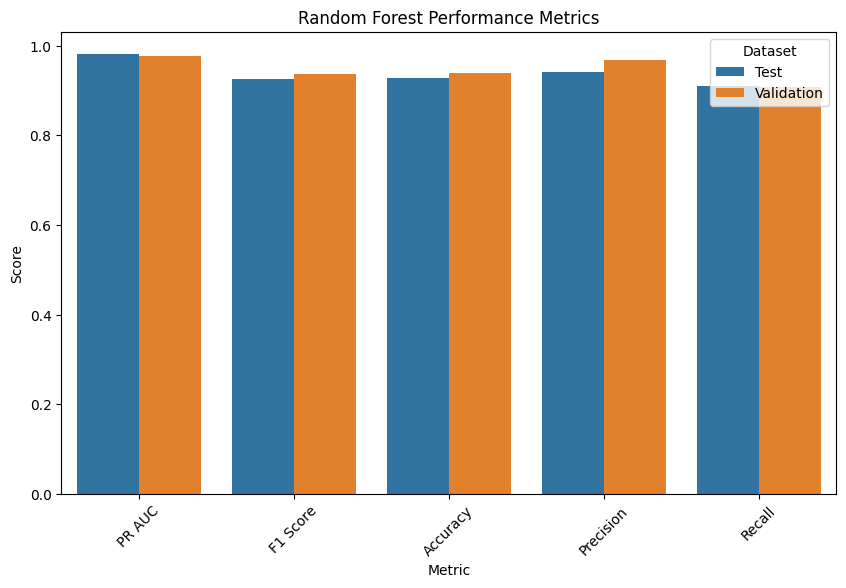

In [0]:
rf_metrics_df = pd.DataFrame(random_forest_metrics)
rf_metrics_melted = rf_metrics_df.melt(id_vars=['Dataset'], value_vars=['PR AUC', 'F1 Score', 'Accuracy', 'Precision', 'Recall'],
                                       var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Dataset', data=rf_metrics_melted)
plt.title('Random Forest Performance Metrics')
plt.xticks(rotation=45)
plt.show()


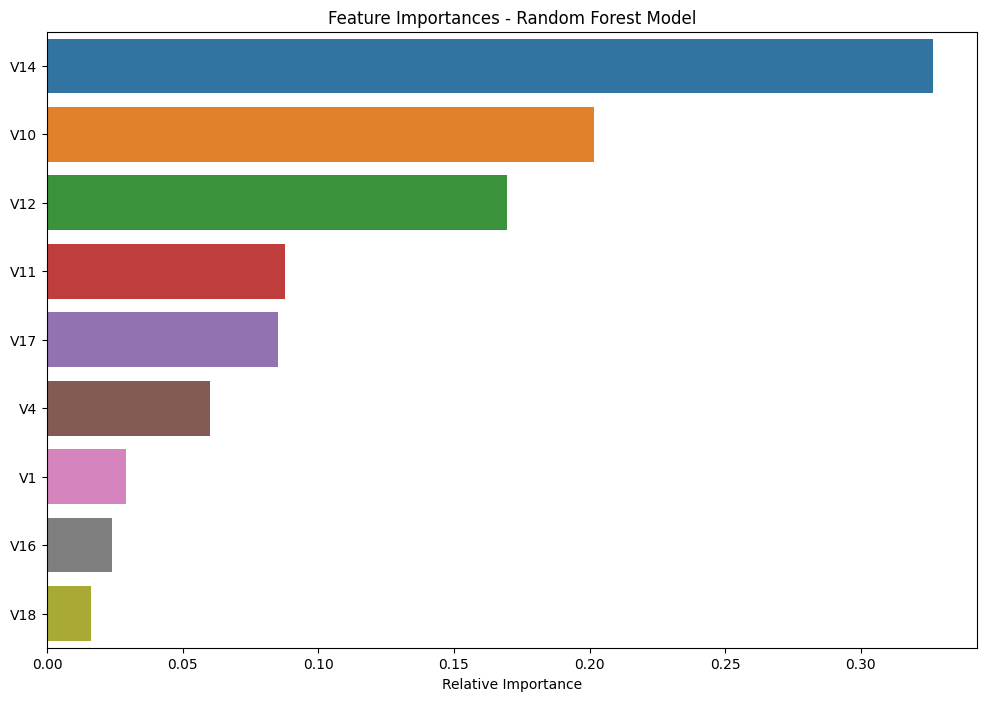

In [0]:
feature_names = X_train.columns  
importances = random_forest_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
sns.barplot(y=[feature_names[i] for i in indices], x=importances[indices])
plt.title('Feature Importances - Random Forest Model')
plt.xlabel('Relative Importance')

plt.savefig('/dbfs/mnt/frauddetectiondata/my_plots/feature_importance.png', bbox_inches='tight', dpi=300)
plt.show()


### Key Performance Indicators

### Precision Recall Curve

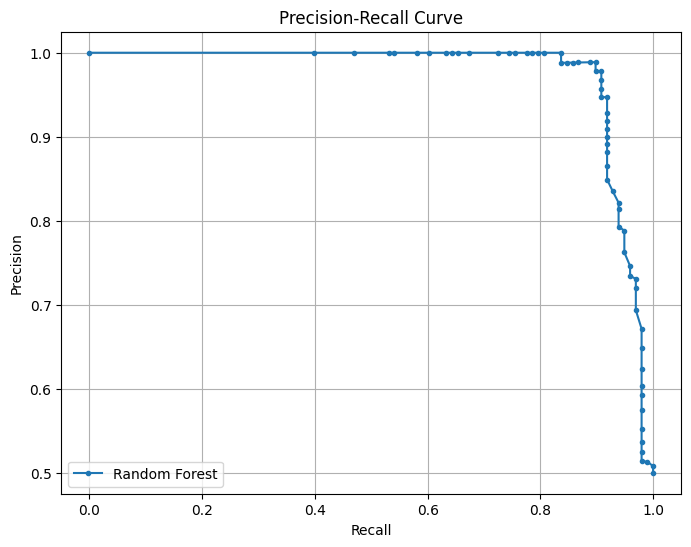

In [0]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_val, y_val are defined and the model is fitted
y_scores = random_forest_model.predict_proba(X_val)[:, 1]  # Get the probabilities for the positive class
precision, recall, thresholds = precision_recall_curve(y_val, y_scores)

# Plotting the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)

plt.savefig('/dbfs/mnt/frauddetectiondata/my_plots/precision_recall_curve.png', bbox_inches='tight', dpi=300)
plt.show()


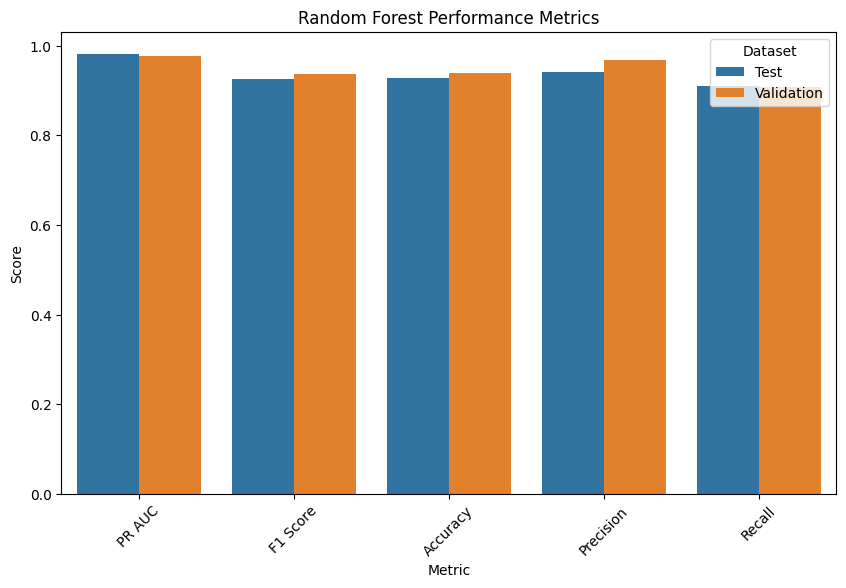

In [0]:
rf_metrics_df = pd.DataFrame(random_forest_metrics)
rf_metrics_melted = rf_metrics_df.melt(id_vars=['Dataset'], value_vars=['PR AUC', 'F1 Score', 'Accuracy', 'Precision', 'Recall'],
                                       var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Dataset', data=rf_metrics_melted)
plt.title('Random Forest Performance Metrics')
plt.xticks(rotation=45)

plt.savefig('/dbfs/mnt/frauddetectiondata/my_plots/rf_performance_metrics.png', bbox_inches='tight', dpi=300)
plt.show()

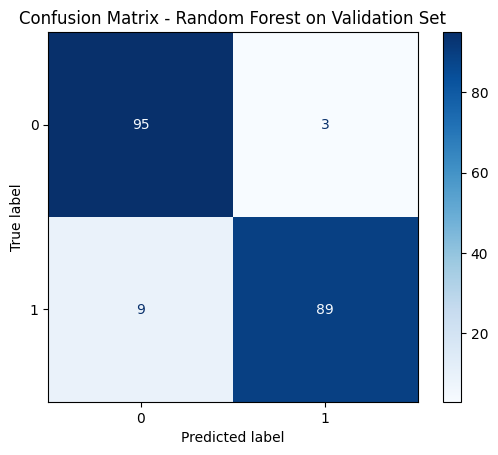

In [0]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_val = random_forest_model.predict(X_val)
cm = confusion_matrix(y_val, y_pred_val)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Random Forest on Validation Set')

plt.savefig('/dbfs/mnt/frauddetectiondata/my_plots/model_confusion_matrix.png', bbox_inches='tight', dpi=300)
plt.show()


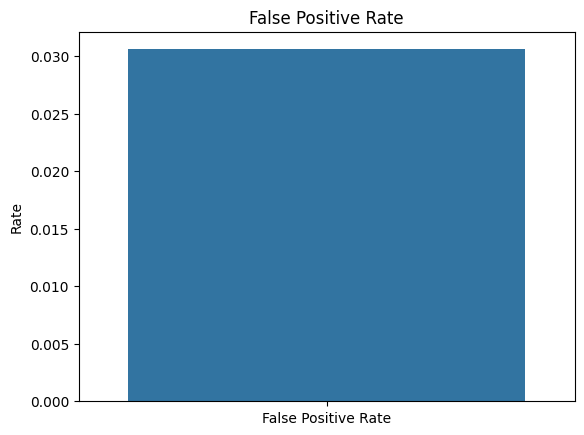

In [0]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_val, y_pred_val).ravel()
fpr = fp / (fp + tn)

# Visualizing FPR
sns.barplot(x=['False Positive Rate'], y=[fpr])
plt.title('False Positive Rate')
plt.ylabel('Rate')
plt.show()


In [0]:
rf_metrics = rf_metrics_df.drop(['Fitted Model'], axis=1) 
rf_metrics.head()

,Model,Dataset,PR AUC,F1 Score,Accuracy,Precision,Recall
0,Random Forest,Test,0.982027,0.925566,0.927215,0.940789,0.910828
1,Random Forest,Validation,0.976540,0.936842,0.938776,0.967391,0.908163


The Random Forest model demonstrated outstanding performance, making it a reliable choice for detecting fraudulent transactions in our dataset. Its high scores in precision and recall are particularly noteworthy because they suggest that the model can minimize false positives (incorrectly flagged legitimate transactions) while effectively identifying most fraudulent transactions. This balance is critical in fraud detection, where the cost of missing a fraudulent transaction can be very high, but so can the inconvenience and customer service implications of falsely flagging legitimate transactions as fraud.

## Conclusion

The project was executed through a series of steps, starting from data collection and preprocessing to model training and evaluation. The chosen Random Forest model demonstrated high performance across various metrics, making it an effective tool for fraud detection. 

The project underscored the importance of using a combination of data preprocessing techniques and machine learning algorithms to handle imbalanced datasets typically encountered in fraud detection scenarios.

This project illustrates the application of machine learning techniques to a critical problem, utilizing a robust stack of tools and technologies. The project's success showcases the ability to leverage data science methodologies to derive meaningful insights and solutions.

## Data Upload

In [0]:
with open("/dbfs/mnt/frauddetectiondata/model_performance_comparison.png", "rb") as data:
    blob_client.upload_blob(data, overwrite=True)

with open("/dbfs/mnt/frauddetectiondata/model_heatmap_comparison.png", "rb") as data:
    blob_client.upload_blob(data, overwrite=True)

with open("/dbfs/mnt/frauddetectiondata/feature_importance.png", "rb") as data:
    blob_client.upload_blob(data, overwrite=True)

with open("/dbfs/mnt/frauddetectiondata/precision_recall_curve.png", "rb") as data:
    blob_client.upload_blob(data, overwrite=True)

with open("/dbfs/mnt/frauddetectiondata/rf_performance_metrics.png", "rb") as data:
    blob_client.upload_blob(data, overwrite=True)

with open("/dbfs/mnt/frauddetectiondata/model_confusion_matrix.png", "rb") as data:
    blob_client.upload_blob(data, overwrite=True)

In [0]:
dbutils.fs.mount(
  source=f"wasbs://{container_name}@{storage_account_name}.blob.core.windows.net/",
  mount_point="/mnt/frauddetectiondata",
  extra_configs={f"fs.azure.sas.{container_name}.{storage_account_name}.blob.core.windows.net": sas_token})


---------------------------------------------------------------------------
ExecutionError                            Traceback (most recent call last)
File <command-121827896927880>, line 1
----> 1 dbutils.fs.mount(
      2   source=f"wasbs://{container_name}@{storage_account_name}.blob.core.windows.net/",
      3   mount_point="/mnt/frauddetectiondata",
      4   extra_configs={f"fs.azure.sas.{container_name}.{storage_account_name}.blob.core.windows.net": sas_token})

File /databricks/python_shell/dbruntime/dbutils.py:362, in DBUtils.FSHandler.prettify_exception_message.<locals>.f_with_exception_handling(*args, **kwargs)
    360 exc.__context__ = None
    361 exc.__cause__ = None
--> 362 raise exc

ExecutionError: An error occurred while calling o2874.mount.
: java.rmi.RemoteException: java.lang.IllegalArgumentException: requirement failed: Directory already mounted: /mnt/frauddetectiondata; nested exception is: 
	java.lang.IllegalArgumentException: requirement failed: Directory alre

In [0]:
filtered_df.to_csv('/dbfs/mnt/frauddetectiondata/fraudmodels.csv', index=False)

blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob_name)

with open("/dbfs/mnt/frauddetectiondata/fraudmodels.csv", "rb") as data:
    blob_client.upload_blob(data, overwrite=True)

### Dashboard Visualization

In [0]:
filtered_df.head(6)

,Model,Dataset,PR AUC,F1 Score,Accuracy,Precision,Recall
0,Random Forest,Test,0.982027,0.925566,0.927215,0.940789,0.910828
1,Random Forest,Validation,0.976540,0.936842,0.938776,0.967391,0.908163
2,KNN,Test,0.975519,0.921569,0.924051,0.946309,0.898089
3,KNN,Validation,0.976576,0.925532,0.928571,0.966667,0.887755
4,SVM,Test,0.986898,0.931148,0.933544,0.959459,0.904459
5,SVM,Validation,0.979221,0.923077,0.928571,1.000000,0.857143


In [0]:
# import dash
# from dash import dcc, html
# import plotly.graph_objs as go
# from dash.dependencies import Input, Output

# # Initialize the Dash app
# app = dash.Dash(__name__)

# # Define the layout of the app
# app.layout = html.Div([
#     html.H1('Random Forest Model Performance'),
#     dcc.Graph(id='performance-graph'),
#     html.Label([
#         "Metric",
#         dcc.Dropdown(
#             id='metric-dropdown',
#             options=[{'label': metric, 'value': metric} for metric in ['F1 Score', 'Accuracy', 'Precision', 'Recall']],
#             value='F1 Score'
#         )
#     ])
# ])

# # Callback to update the graph based on dropdown selection
# @app.callback(
#     Output('performance-graph', 'figure'),
#     [Input('metric-dropdown', 'value')]
# )
# def update_graph(selected_metric):
#     # Filter the DataFrame based on the selected metric
#     filtered_df = metrics_df[['Model', 'Dataset', selected_metric]]
    
#     # Create a bar chart
#     fig = go.Figure()
#     for dataset in filtered_df['Dataset'].unique():
#         df_subset = filtered_df[filtered_df['Dataset'] == dataset]
#         fig.add_trace(go.Bar(x=df_subset['Model'], y=df_subset[selected_metric], name=dataset))
    
#     fig.update_layout(barmode='group', title=f'Random Forest Model {selected_metric} Comparison')
#     return fig

# # Run the app
# if __name__ == '__main__':
#     app.run_server(debug=True)
